In [1]:
%matplotlib widget

In [2]:
import torch

side = 4
state_size = 4 * 4 * 3
device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
dtype = torch.float32
# if device.type == "mps" else torch.float64


In [3]:
import torch
import copy
import numpy as np

# from core import state_size

statespace_size = state_size


# The function "prepare_torch" needs to be called once and only once at the start of your program to initialise PyTorch and generate the two Q-networks. It returns the target model (for testing).
def prepare_torch():
    global statespace_size
    global model, model_hat
    global optimizer
    global loss_fn
    l1 = statespace_size
    l2 = 150
    l3 = 100
    l4 = 4
    model = torch.nn.Sequential(
        torch.nn.Linear(l1, l2),
        torch.nn.ReLU(),
        torch.nn.Linear(l2, l3),
        torch.nn.ReLU(),
        torch.nn.Linear(l3, l4),
    ).to(device)
    model_hat = copy.deepcopy(model).to(device)
    model_hat.load_state_dict(model.state_dict())
    loss_fn = torch.nn.MSELoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return model_hat


# The function "update_target" copies the state of the prediction network to the target network. You need to use this in regular intervals.
def update_target():
    global model, model_hat
    model_hat.load_state_dict(model.state_dict())


# The function "get_qvals" returns a numpy list of qvals for the state given by the argument _based on the prediction network_.
def get_qvals(state):
    return model(state).to(device)


# The function "get_maxQ" returns the maximum q-value for the state given by the argument _based on the target network_.
def get_maxQ(s):
    maxxed = torch.max(model_hat(s), dim=1)
    return torch.max(model_hat(s), dim=1).values.float()


# The function "train_one_step_new" performs a single training step. It returns the current loss (only needed for debugging purposes). Its parameters are three parallel lists: a minibatch of states, a minibatch of actions, a minibatch of the corresponding TD targets and the discount factor.
def train_one_step(states, actions, targets):
    # print(states)
    # print(states.shape)
    # for s in states:
    # print(s.shape)
    # pass to this function: state1_batch, action_batch, TD_batch
    global model, model_hat
    # state1_batch = torch.cat([torch.from_numpy(s).float() for s in states])
    state1_batch = states.to(device)
    action_batch = actions.to(device)
    # print(action_batch.shape)
    # print(state1_batch.shape)
    Q1 = model(state1_batch)
    X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
    Y = targets.clone().detach().to(device).float()
    loss = loss_fn(X, Y)
    # print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item() / len(X)


In [4]:
from typing import TYPE_CHECKING, Tuple, List

import numpy as np
import random
import torch

class ExpBuffer:
    def __init__(self):
        self.max = 1000
        self.itr = 0
        self.has_reached = False

        self.states = torch.empty((self.max, state_size), dtype=dtype)
        self.actions = torch.empty((self.max,), dtype=dtype)
        self.rewards = torch.empty((self.max,), dtype=dtype)
        self.next_states = torch.empty((self.max, state_size), dtype=dtype)
        self.is_terminals = torch.empty((self.max,), dtype=torch.bool)
        pass

    def insert(self, state, action, reward, next_state, is_terminal):
        self.itr %= self.max
        self.states[self.itr] = state
        self.actions[self.itr] = action
        self.rewards[self.itr] = reward
        self.next_states[self.itr] = next_state
        self.is_terminals[self.itr] = is_terminal
        self.itr += 1

        if self.itr >= self.max:
            self.has_reached = True

    def extract(self, batch_size) -> Tuple[List[List[int]], List[int], List[float]]:
        indices = np.random.randint(
            0, self.max if self.has_reached else self.itr, batch_size
        )
        # print(len(self.states))
        # print(indices)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.is_terminals[indices],
        )

    def __len__(self):
        return len(self.states)


class Agent:
    def __init__(self, idx, all_states, actions):
        # Agent property (for illustration purposes)
        self.is_having_item = False
        self.total_reward = 0

        self.actions = actions  # TODO: encode different action for different state. How to initialize Q-Table
        self.idx = idx

        # Initialize Q Table for all state-action to be 0
        # TODO: use multi-D np array
        self.min_buffer = 200
        self.step_count = 0
        self.C = 500
        self.Q = np.zeros((all_states, len(actions)))

        # Initialize Learning param
        # TODO: fix resetting epsilon
        self.epsilon = 1.0
        self.epsilon_decay = 0.999  # TODO: reduce the decay (ie. increase the number)
        self.epsilon_min = 0.1
        self.gamma = 0.997

        # self.alpha = 0.1

        self.buffer = ExpBuffer()

        prepare_torch()

    # ----- Core Functions ----- #
    def choose_action(self, state: "State", explore=True):
        if explore and np.random.rand() < self.epsilon:
            return random.choice(self.actions)
        else:
            # Extract immutable state information
            state_i = self.massage(state)
            idx = torch.argmax(get_qvals(state_i))
            return self.actions[idx]

    def update_learn(
        self,
        state: "State",
        action: "Action",
        reward: int,
        next_state: "State",
        is_terminal: bool,
        learn=True,
    ):
        self.update(next_state, reward)

        # Extract immutable state information
        # nxt_state_i = self.massage(next_state)

        if not learn:
            return

        # # All states (including terminal states) have initial Q-values of 0 and thus there is no need for branching for handling terminal next state
        # self.Q[state_i][self.actions.index(action)] += self.alpha * (
        #     reward
        #     + self.gamma * np.max(self.Q[nxt_state_i])
        #     - self.Q[state_i][self.actions.index(action)]
        # )

        state_i = self.massage(state)
        nxt_state_i = self.massage(next_state)
        # target_val = self.gamma * get_maxQ(nxt_state_i) + reward
        # if is_terminal:
        #     target_val = torch.tensor(reward)

        # next_qa = np.copy(current_qa)
        # next_qa[np.argmax(next_qa)] = target_val
        self.buffer.insert(
            state_i, self.actions.index(action), reward, nxt_state_i, is_terminal
        )
        if len(self.buffer) >= self.min_buffer:
            states, actions, rewards, next_states, is_terminals = self.buffer.extract(
                200
            )
            rewards = rewards.to(device)
            indices = is_terminals.nonzero().to(device)
            targets = self.gamma * get_maxQ(next_states.to(device)) + rewards
            targets[indices] = rewards[
                indices
            ]  # For terminal states, target_val is reward
            # print(states, actions, targets)
            # print(states.shape, actions.shape, targets.shape)
            loss = train_one_step(states, actions, targets)

        if self.step_count >= self.C:
            update_target()
            self.step_count = 0
        else:
            self.step_count += 1

        # Epsilon decay
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return loss

    # ----- Public Functions ----- #
    def has_item(self):
        return self.is_having_item

    def get_total_reward(self):
        return self.total_reward

    def update(self, state: "State", reward=0):
        self.is_having_item = state.item_taken()
        self.total_reward += reward

    def reset(self):
        self.is_having_item = False
        self.total_reward = 0

    def get_q_table(self):
        return self.Q

    # ----- Private Functions ----- #
    # Extract immutable information from State object
    def massage(self, state: "State"):
        state_i = state.extract_state(self.idx).to(device).float()
        return state_i + 0.001  # 5 Minutes
        # return state_i + torch.rand(state_size).to(device) / 100.0  # 15 Minutes


In [5]:
from typing import Tuple, TYPE_CHECKING

class Cell:
    def __init__(self, pos):
        x, y = pos
        self.x = x
        self.y = y

    # returns: score delta, (new_coordinate_x, new_coordinate_y)
    def interact(self, other: "Agent") -> Tuple[int, Tuple[int, int]]:
        return -1, (self.x, self.y)

    def __copy__(self):
        return Cell((self.x, self.y))

    def __deepcopy__(self, memo):
        return self.__copy__()


class Goal(Cell):
    def __init__(self, pos):
        x, y = pos
        self.x = x
        self.y = y
        self.reached = False

    def interact(self, other: "Agent"):
        if other.has_item() and not self.reached:
            self.reached = True
            return 50, (self.x, self.y)
        else:
            return -1, (self.x, self.y)

    def has_reached(self):
        return self.reached

    def __copy__(self):
        copy = Goal((self.x, self.y))
        copy.reached = self.reached
        return copy

    def __deepcopy__(self, memo):
        return self.__copy__()


class Item(Cell):
    def __init__(self, pos):
        self.taken = False
        x, y = pos
        self.x = x
        self.y = y

    def interact(self, other: "Agent"):
        if not self.taken and not other.has_item():
            # agent update is done in agent.update(...)
            self.taken = True
            return 50, (self.x, self.y)

        return -1, (self.x, self.y)

    def get_pos(self):
        return self.x, self.y

    def __copy__(self):
        copy = Item((self.x, self.y))
        copy.taken = self.taken
        return copy

    def __deepcopy__(self, memo):
        return self.__copy__()


class Wall(Cell):
    def __init__(self, pos, dimensions):
        x, y = pos
        self.x = x
        self.y = y

        width, height = dimensions
        self.new_x = min(width - 1, max(0, x))
        self.new_y = min(height - 1, max(0, y))

    def interact(self, other: "Agent"):
        return -10, (self.new_x, self.new_y)

    def __copy__(self):
        return Wall((self.x, self.y))

    def __deepcopy__(self, memo):
        return self.__copy__()


In [6]:
from typing import TYPE_CHECKING, List, Tuple, Dict, Set

import random

class GridFactory:
    # Getting a random location in a grid, excluding certain locations
    def get_random_pos(
        width: int, height: int, exclude: List[Tuple[int, int]] = []
    ) -> Tuple[int, int]:
        while True:
            position = (
                random.randint(0, width - 1),
                random.randint(0, height - 1),
            )
            if position not in exclude:
                return position


class Grid:
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        self.max_reward = 0

        self.state: Dict[Tuple[int, int], Cell] = (
            {}
        )  # TODO: multiple entities in one cell
        self.lookup: set[Cell] = set()  # Interactive tiles
        self.agents: List["Agent"] = []
        self.agent_positions: List[Tuple[int, int]] = []

        self.init_environment()

    # ----- Init Functions ----- #
    def init_environment(self):
        for x in range(-1, self.width + 1):
            for y in range(-1, self.height + 1):
                if x < 0 or x >= self.width:
                    self.state[(x, y)] = Wall((x, y), (self.width, self.height))
                elif y < 0 or y >= self.height:
                    self.state[(x, y)] = Wall((x, y), (self.width, self.height))
                else:
                    self.state[(x, y)] = Cell((x, y))

    # ----- Core Functions ----- #
    def move(
        self, actions: List["Action"]
    ):  # List of actions, in the same order as self.agents
        # Update agent to temporary location according to move
        temp_positions = [
            self.process_action(action, agent_pos)
            for action, agent_pos in zip(actions, self.agent_positions)
        ]

        # Retreive reward and new location according to Entity.interaction
        reward_new_positions = [
            self.state[(x, y)].interact(agent)
            for agent, (x, y) in zip(self.agents, temp_positions)
        ]
        rewards, new_positions = zip(*reward_new_positions)

        # Update new positions
        self.agent_positions = new_positions

        # Return move results, in the same order as self.agents
        return [
            (reward, self.get_state(), self.get_state().is_terminal())
            for reward in rewards
        ]

    # ----- Private Functions ----- #
    def process_action(
        self, action: List["Action"], agent_position: List[Tuple[int, int]]
    ):
        # Move according to action
        x, y = agent_position
        dx, dy = self.interpret_action(action)
        return x + dx, y + dy

    def interpret_action(self, action: "Action"):
        if action == Action.NORTH:
            return 0, -1
        if action == Action.SOUTH:
            return 0, 1
        if action == Action.EAST:
            return 1, 0
        if action == Action.WEST:
            return -1, 0

    def set_interactive_tiles(self):
        self.lookup.clear()
        used_pos = []

        # TODO: extract repeated code

        # Assign goal to set position
        goal_pos = GridFactory.get_random_pos(self.width, self.height, used_pos)
        # goal_pos = (self.width - 1, self.height - 1)
        goal = Goal(goal_pos)
        self.state[goal_pos] = goal
        self.lookup.add(goal)
        used_pos.append(goal_pos)

        # Assign items to a random position in the remaining tiles
        item_pos = GridFactory.get_random_pos(self.width, self.height, used_pos)
        item = Item(item_pos)
        self.state[item_pos] = item
        self.lookup.add(item)
        used_pos.append(item_pos)

        # Assign agents to random positions
        self.agent_positions = []
        for _ in self.agents:
            agent_pos = GridFactory.get_random_pos(self.width, self.height, used_pos)
            used_pos.append(agent_pos)
            self.agent_positions.append(agent_pos)

        # Future proofing: update agents in case they spwaned on an item
        for agent in self.agents:
            agent.update(State(self.agent_positions, self.lookup))

        self.max_reward = GridUtil.calculate_max_reward(self)

    # ----- Public Functions ----- #
    def reset(self):
        self.init_environment()
        self.set_interactive_tiles()

    def add_agent(self, agent: "Agent"):
        self.agents.append(agent)

    def get_state(self):
        return State(self.agent_positions, self.lookup)

    def get_size(self):
        return self.width, self.height

    def get_max_reward(self):
        return self.max_reward


class GridUtil:
    def calculate_max_reward(grid: Grid):
        # TODO: can only work with one agent and one item ATM
        x1, y1 = grid.get_state().get_agent_positions()[0]
        x2, y2 = grid.get_state().get_item_positions()[0]
        x3, y3 = grid.get_state().get_goal_positions()

        # Manhanttan distance from agent to obj and obj to goal
        dist_to_obj = abs(x1 - x2) + abs(y1 - y2)
        dist_to_goal = abs(x2 - x3) + abs(y2 - y3)

        # +100 for reward and +2 for 2 unneeded mark deduction when stepping on item and goal respectively
        return (dist_to_obj + dist_to_goal) * -1 + 102


In [7]:
class Action:
    NORTH = "N"
    WEST = "W"
    EAST = "E"
    SOUTH = "S"

import itertools
import numpy as np
import torch

from copy import deepcopy

class State:
    def __init__(self, agent_positions, lookup):
        self.agent_positions = agent_positions
        self.lookup = deepcopy(lookup)

    def get_possible_actions():
        # Generate possible actions
        return [Action.NORTH, Action.SOUTH, Action.EAST, Action.WEST]

    # TODO: fix hardcode
    def get_possible_states(width, height):
        # Generate all possible states
        return state_size
        positions = [(x, y) for x in range(width) for y in range(height)]
        has_items = [True, False]
        return itertools.product(positions, positions, has_items)

    # ----- Private Functions ----- #
    def get_goal(self) -> "Goal":
        return next((x for x in self.lookup if isinstance(x, Goal)), [None])

    def get_items(self):
        return [x for x in self.lookup if isinstance(x, Item)]

    def get_item_positions(self):
        return [item.get_pos() for item in self.get_items()]

    # TODO: fix hardcode
    def item_taken(self):
        item = next((x for x in self.lookup if isinstance(x, Item)), [None])
        return item.taken

    def extract_state(self, idx):
        x, y = self.agent_positions[idx]
        x2, y2 = self.get_item_positions()[0]
        x3, y3 = self.get_goal_positions()
        # print(x, y, x2, y2, x3, y3)
        # TODO: remove hardcoded item_pos indices
        # return agent_pos, item_pos[0], self.has_item()
        state = torch.empty(state_size, dtype=dtype)
        state[x * side + y] = 1
        if not self.item_taken():
            state[side**2 + x2 * side + y2] = 1
        state[side**2 * 2 + x3 * side + y3] = 1

        return state

    # ----- Information Extraction ----- #
    def get_agent_positions(self):
        return self.agent_positions

    # TODO: fix hardcode
    def get_goal_positions(self):
        goal = self.get_goal()
        return goal.x, goal.y

    def get_item_positions(self):
        return [item.get_pos() for item in self.get_items()]

    # TODO: fix hardcode
    def is_terminal(self):
        goal = self.get_goal()
        return goal.has_reached()

    def get_untaken_item_pos(self):
        untaken_items = filter(lambda i: not i.taken, self.get_items())
        return [i.get_pos() for i in untaken_items]


In [8]:
from multiprocessing import Array
from typing import List


class Storage:
    def __init__(self, max_itr: int):
        self.itr = 0
        self.max_itr = max_itr

        # TODO: max_itr could be dynamic
        self.iterations = Array("i", range(max_itr))
        self.losses = Array("i", max_itr)
        self.epsilon = Array("f", max_itr)
        self.test_loss = []
        self.ml_losses = []

    def reset_counter(self):
        self.itr = 0

    def append_loss_epsilon(self, loss: int, epsilon: float):
        if self.itr >= self.max_itr:
            self.itr = 0
        self.losses[self.itr] = loss
        self.epsilon[self.itr] = epsilon
        self.itr += 1

    def append_test_loss(self, test_loss: int):
        self.test_loss.append(test_loss)

    def reset_test_loss(self):
        self.test_loss = []

    def append_ml_losses(self, ml_losses: List[float]):
        self.ml_losses += ml_losses

    def get_all(self):
        return self.iterations, self.losses, self.epsilon, self.test_loss


In [9]:
from typing import TYPE_CHECKING, List
import datetime

class Trainer:
    def __init__(self, max_itr):
        self.max_itr = max_itr

    def bind(
        self, model: "Model", storage: "Storage", grid: "Grid", agents: List["Agent"]
    ):
        self.model = model
        self.storage = storage
        self.grid = grid
        self.agents = agents

    def train(self, itr=1):
        start = datetime.datetime.now()
        print(f"Start Time: {start}")
        self.model.reset()
        for i in range(itr):
            (loss, reward, epsilon, ml_losses) = self.train_one_game()
            # self.storage.append_loss_epsilon(loss, epsilon)

            self.storage.append_ml_losses(ml_losses)
            if (i + 1) % 100 == 0:
                print(
                    f"Epoch: {i+1}/{itr} -- Time Elapsed: {datetime.datetime.now() - start}"
                )
        return self.storage.ml_losses

    def test(self, itr=1):
        self.model.reset()
        self.storage.reset_test_loss()
        # for i in range(self.max_itr):
        #     self.storage.test_loss[i] = 0
        for _ in range(itr):
            (loss, reward, epsilon, _) = self.train_one_game(learn=False)
            # self.storage.append_test_loss(loss)
            self.storage.append_test_loss(loss)
        return self.storage.test_loss

    def train_one_game(self, learn=True):
        self.model.reset()
        max_reward = self.grid.get_max_reward()

        max_step_count = 50 if learn else 50
        step_count = 0
        ml_losses = []
        while not self.grid.get_state().is_terminal() and step_count < max_step_count:
            ml_loss = self.step(learn)
            if ml_loss is not None:
                ml_losses.append(ml_loss)
            step_count += 1

        total_reward = sum(map(lambda a: a.get_total_reward(), self.agents))
        loss = max_reward - total_reward
        return loss, total_reward, self.agents[0].epsilon, ml_losses  # TODO: 0

    def step(self, learn=True):
        if self.grid.get_state().is_terminal():
            return

        state = self.grid.get_state()
        actions = [agent.choose_action(state, explore=learn) for agent in self.agents]
        results = self.grid.move(actions)
        loss = None

        for action, (reward, next_state, terminal), agent in zip(
            actions, results, self.agents
        ):
            if learn:
                loss = agent.update_learn(state, action, reward, next_state, terminal)
            else:
                agent.update(next_state, reward)
        return loss

    def test_in_background(self, ep=1000):
        gp, tp = get_test_process(self.storage, self, ep)
        gp.start()
        tp.start()
        gp.join()
        tp.join()

    def train_in_background(self):
        gp, tp, conn1 = get_process(self.storage, self)
        gp.start()
        tp.start()
        gp.join()
        tp.join()

        name = conn1.recv()
        # TODO: return array of trained_Q
        trained_Q = get_np_from_name(name)
        return trained_Q


In [10]:
class Controller:
    # Iterate by number of games
    def __init__(self):
        self.auto_reset = True

    def bind(self, model: "Model"):
        self.model = model
        return self

    def add_helper(self, storage: "Storage", trainer: "Trainer"):
        self.storage = storage
        self.trainer = trainer
        return self

    def toggle_auto_reset(self):
        self.auto_reset = not self.auto_reset
        return self.auto_reset

    def next(self):
        if self.model.has_ended() and self.auto_reset:
            self.model.reset()
        self.trainer.step(learn=False)
        return

    def train(self, itr=1):
        return self.trainer.train(itr)

    def test(self, itr=1):
        return self.trainer.test(itr)

    def reset(self):
        self.model.reset()

    def get_metrics(self):
        itrs, losses, epsilons, test_losses = self.storage.get_all()
        return itrs, losses, epsilons

    def test_in_background(self, ep=1000):
        self.trainer.test_in_background(ep)

    def train_in_background(self):
        trained_Q = self.trainer.train_in_background()
        # TODO: fix hardcode
        self.model.agents[0].Q = trained_Q


In [11]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

class Graph:
    def __init__(self, storage: "Storage", fig, axs):
        self.storage = storage
        self.fig = fig
        self.ax1, self.ax2 = axs

        self.storage = storage
        self.ani = animation.FuncAnimation(
            self.fig, self.draw, frames=self.frames, interval=100, save_count=100
        )

        plt.show()

    def frames(self):
        while True:
            yield None

    # Compulsory unused argument
    def draw(self, args):
        self.plot_losses(
            self.ax1,
            self.storage.iterations,
            self.storage.losses,
        )
        self.plot_epsilon(
            self.ax2,
            self.storage.iterations,
            self.storage.epsilon,
        )

    def plot_losses(self, ax, iterations, loss):
        # Plotting the loss in the first subplot
        ax.plot(iterations, loss, color="blue", label="Loss")
        ax.set_title("Loss")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")

    def plot_epsilon(self, ax, iterations, epsilon):
        # Plotting the loss in the first subplot
        ax.plot(iterations, epsilon, color="blue", label="Loss")
        ax.set_title("Epsilon")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Epsilon")


class TestGraph:
    def __init__(self, controller, fig, ax):
        self.controller = controller
        self.fig = fig
        self.ax = ax

        self.controller = controller
        self.ani = animation.FuncAnimation(
            self.fig, self.draw, frames=self.frames, interval=100, save_count=100
        )

        plt.show()

    def frames(self):
        while True:
            yield None

    def draw(self, args):
        self.plot_losses(
            self.ax,
            self.controller.iterations,
            self.controller.test_loss,
        )

    def plot_losses(self, ax, iterations, loss):
        # Plotting the loss in the first subplot
        ax.plot(iterations, loss, color="blue", label="Loss")
        ax.set_title("Loss")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")


class MLGraph:
    def __init__(self, ml_losses, fig, ax):
        ax.plot(range(len(ml_losses)), ml_losses, label="Loss")
        # ax.set_title("Loss")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        pass

    def show(self):

        # Display the plots
        plt.tight_layout()
        plt.show()
        pass


In [12]:
import matplotlib.pyplot as plt
import numpy as np

from typing import TYPE_CHECKING
from multiprocessing import Process, shared_memory, Pipe

def draw_graphs(storage: "Storage"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    graph = Graph(storage, fig, axs)


def train(trainer: "Trainer", connection, ep):
    trainer.train(ep)
    # TODO: remove hardcode
    q = trainer.model.agents[0].get_q_table()

    shm = shared_memory.SharedMemory(create=True, size=q.nbytes)
    b = np.ndarray(q.shape, dtype=q.dtype, buffer=shm.buf)
    b[:] = q[:]
    connection.send(shm.name)
    shm.close()


def get_process(storage: "Storage", trainer: "Trainer"):
    conn1, conn2 = Pipe()
    graph_p = Process(
        target=draw_graphs,
        args=[
            storage,
        ],
    )
    # TODO: remove hardcode
    train_p = Process(target=train, args=[trainer, conn2, 1000])
    return graph_p, train_p, conn1


def test(trainer: "Trainer", ep):
    trainer.test(ep)


def draw_test_graph(storage: "Storage"):
    fig, axs = plt.subplots()
    graph = TestGraph(storage, fig, axs)


def get_test_process(storage: "Storage", trainer: "Trainer", ep=1000):
    graph_p = Process(
        target=draw_test_graph,
        args=[storage],
    )
    test_p = Process(target=test, args=[trainer, ep])
    return graph_p, test_p


def get_np_from_name(name):
    existing_shm = shared_memory.SharedMemory(name=name)
    # TODO: remove hardcode
    q = np.ndarray((5**5, 4), buffer=existing_shm.buf)
    s = np.copy(q)
    existing_shm.close()
    existing_shm.unlink()
    return s


In [13]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

class Graph:
    def __init__(self, storage: "Storage", fig, axs):
        self.storage = storage
        self.fig = fig
        self.ax1, self.ax2 = axs

        self.storage = storage
        self.ani = animation.FuncAnimation(
            self.fig, self.draw, frames=self.frames, interval=100, save_count=100
        )

        plt.show()

    def frames(self):
        while True:
            yield None

    # Compulsory unused argument
    def draw(self, args):
        self.plot_losses(
            self.ax1,
            self.storage.iterations,
            self.storage.losses,
        )
        self.plot_epsilon(
            self.ax2,
            self.storage.iterations,
            self.storage.epsilon,
        )

    def plot_losses(self, ax, iterations, loss):
        # Plotting the loss in the first subplot
        ax.plot(iterations, loss, color="blue", label="Loss")
        ax.set_title("Loss")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")

    def plot_epsilon(self, ax, iterations, epsilon):
        # Plotting the loss in the first subplot
        ax.plot(iterations, epsilon, color="blue", label="Loss")
        ax.set_title("Epsilon")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Epsilon")


class TestGraph:
    def __init__(self, controller, fig, ax):
        self.controller = controller
        self.fig = fig
        self.ax = ax

        self.controller = controller
        self.ani = animation.FuncAnimation(
            self.fig, self.draw, frames=self.frames, interval=100, save_count=100
        )

        plt.show()

    def frames(self):
        while True:
            yield None

    def draw(self, args):
        self.plot_losses(
            self.ax,
            self.controller.iterations,
            self.controller.test_loss,
        )

    def plot_losses(self, ax, iterations, loss):
        # Plotting the loss in the first subplot
        ax.plot(iterations, loss, color="blue", label="Loss")
        ax.set_title("Loss")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")


class MLGraph:
    def __init__(self, ml_losses, fig, ax):
        ax.plot(range(len(ml_losses)), ml_losses, label="Loss")
        # ax.set_title("Loss")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        pass

    def show(self):

        # Display the plots
        plt.tight_layout()
        plt.show()
        pass


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

from matplotlib.widgets import Button
from typing import Tuple, TypeAlias, TYPE_CHECKING

Coordinates: TypeAlias = Tuple[float, float, float, float]

class Visualization:
    def __init__(self, fig, ax):
        self.fig = fig
        self.ax = ax
        self.animating = False

    def bind(self, model: "Model", controller: "Controller", storage: "Storage"):
        self.model = model
        self.controller = controller
        self.storage = storage
        return self

    def show(self):
        assert self.model is not None
        assert self.controller is not None

        self.add_ui_elements()
        self.fig.canvas.mpl_connect("close_event", self.on_close)
        self.ani = animation.FuncAnimation(
            self.fig, self.draw, frames=self.frames, interval=200, save_count=100
        )
        self.animating = True
        plt.show()

    def get_info(self):
        info = self.model.get_agent_info()
        items = self.model.get_untaken_items()
        tot_reward = self.model.get_total_reward()
        max_reward = self.model.get_max_reward()
        return info, items, tot_reward, max_reward

    def frames(self):
        while True:
            if self.animating:
                self.controller.next()
                yield self.get_info()
            else:
                yield self.get_info()

    # ----- ----- ----- ----- Drawing Functions  ----- ----- ----- ----- #

    def draw(self, args):
        info, items, tot_reward, max_reward = args

        self.ax.clear()
        self.draw_grid()
        self.draw_agent(info)
        self.draw_item(items)

        self.reward.set_text(f"Reward: {tot_reward}")
        self.max_reward.set_text(f"Max Reward: {max_reward}")

        # Check if the environment is terminal
        if self.model.has_ended():
            self.draw_complete()

        # Early return if animating, since animation automatically refreshes canvas
        if self.animating:
            return

        self.fig.canvas.draw()

    def draw_grid(self):
        width, height = self.model.get_size()
        for x in range(width):
            for y in range(height):
                rect = patches.Rectangle(
                    (x, y), 1, 1, linewidth=1, edgecolor="black", facecolor="white"
                )
                self.ax.add_patch(rect)
        self.ax.set_xlim(0, width)
        self.ax.set_ylim(height, 0)
        self.ax.set_aspect("equal")

        # Move x-axis labels to the top
        self.ax.xaxis.set_label_position("top")
        self.ax.xaxis.tick_top()

        # Draw target
        # TODO: cater multiple goals
        tx, ty = self.model.get_target_location()
        target_patch = patches.Rectangle(
            (tx, ty), 1, 1, linewidth=1, edgecolor="black", facecolor="green"
        )
        self.ax.add_patch(target_patch)

    def draw_agent(self, info):
        # Draw agent
        for pos, has_item in info:
            ax, ay = pos
            agent_color = "blue" if not has_item else "orange"
            agent_patch = patches.Circle((ax + 0.5, ay + 0.5), 0.3, color=agent_color)
            self.ax.add_patch(agent_patch)

    def draw_item(self, items):
        for item in items:
            ix, iy = item
            item_patch = patches.Circle((ix + 0.5, iy + 0.5), 0.2, color="red")
            self.ax.add_patch(item_patch)

    def draw_complete(self):
        self.ax.text(
            0.5,
            0.5,
            "Complete",
            horizontalalignment="center",
            verticalalignment="center",
            transform=self.ax.transAxes,
            fontsize=20,
            color="red",
        )

    # ----- ----- ----- ----- Render UI Element  ----- ----- ----- ----- #

    def add_ui_elements(self):
        self.init_buttons()
        self.init_text()

    def init_buttons(self):
        # Add button for next step
        self.next_step_btn = self.add_button(
            [0.85, 0.01, 0.12, 0.075], "Next Step", self.on_next
        )
        # Add button for reset
        self.reset_btn = self.add_button(
            [0.85, 0.11, 0.12, 0.075], "Reset", self.on_reset
        )
        # Add button for animation on/off
        self.toggle_anim_btn = self.add_button(
            [0.85, 0.21, 0.12, 0.075], "Anim\nOn", self.on_toggle_anim
        )
        # Add button for auto reset on/off
        self.toggle_auto_reset_btn = self.add_button(
            [0.85, 0.31, 0.12, 0.075], "Auto Reset\nOn", self.on_auto_reset
        )
        # # Add button for training
        # self.bg_train_btn = self.add_button(
        #     [0.85, 0.41, 0.12, 0.075], "Train 1000", self.on_train(1000, blocking=False)
        # )
        # Add button for training
        self.block_train_btn = self.add_button(
            [0.85, 0.41, 0.12, 0.075],
            "Train 2500",
            self.on_train(2500, blocking=True),
        )
        # Add button for training grpah
        self.show_graph_button = self.add_button(
            [0.85, 0.51, 0.12, 0.075], "Train Graph", self.on_show_graph
        )
        # Add button for testing
        self.test_button = self.add_button(
            [0.85, 0.61, 0.12, 0.075], "Test", self.on_test(100, blocking=True)
        )

    def init_text(self):
        # Add text box for cumulative reward
        self.reward = self.add_text(
            [0.01, 0.01, 0.2, 0.075], f"Reward: {self.model.get_total_reward()}"
        )

        # Add text box for max reward
        self.max_reward = self.add_text(
            [0.25, 0.01, 0.2, 0.075],
            f"Max Reward: {self.model.get_max_reward()}",
        )

    def add_button(self, coordinates: Coordinates, text, on_click):
        axis = plt.axes(coordinates)
        # axis = self.ax
        button = Button(axis, text)
        button.on_clicked(on_click)

        return button

    def add_text(self, coordinates: Coordinates, text):
        axis = plt.axes(coordinates)
        # axis = self.ax
        textbox = axis.text(
            0.5,
            0.5,
            text,
            horizontalalignment="center",
            verticalalignment="center",
            transform=axis.transAxes,
            fontsize=12,
        )
        axis.axis("off")
        return textbox

    # ----- ----- ----- ----- Event Handlers  ----- ----- ----- ----- #

    def on_close(self, e):
        pass

    def on_show_graph(self, e):
        fig2, ax2 = plt.subplots()
        MLGraph(self.storage.ml_losses, fig2, ax2).show()

    def on_test(self, episodes, blocking=False):
        def non_blocking_test(e):
            self.before_auto_train()
            self.controller.test_in_background(episodes)
            self.after_auto_train()

        def blocking_test(e):
            losses = self.controller.test(episodes)
            fig2, ax2 = plt.subplots()
            MLGraph(losses, fig2, ax2).show()

        return blocking_test if blocking else non_blocking_test

    def on_train(self, episodes, blocking=False):
        def blocking_train(e):
            ml_losses = self.controller.train(episodes)
            fig2, ax2 = plt.subplots()
            MLGraph(ml_losses, fig2, ax2).show()

        def non_blocking_train(e):
            self.before_auto_train()
            self.controller.train_in_background()
            self.after_auto_train()

        return blocking_train if blocking else non_blocking_train

    def on_auto_reset(self, event):
        auto_reset_is_on = self.controller.toggle_auto_reset()
        if auto_reset_is_on:
            self.toggle_auto_reset_btn.label.set_text("Auto Reset\nOn")
        else:
            self.toggle_auto_reset_btn.label.set_text("Auto Reset\nOff")
        plt.show()

    def on_toggle_anim(self, event):
        if self.animating:
            self.toggle_anim_btn.label.set_text("Anim\nOff")
        else:
            self.toggle_anim_btn.label.set_text("Anim\nOn")

        self.animating = not self.animating
        plt.show()

    def on_reset(self, event):
        self.model.reset()
        self.draw(self.get_info())

    def on_next(self, e):
        self.controller.next()
        self.draw(self.get_info())

    # ----- ----- ----- ----- Helper Functions  ----- ----- ----- ----- #

    def before_auto_train(self):
        self.animating = False
        self.controller.reset()

        self.toggle_anim_btn.label.set_text("Anim\nOff")
        self.draw(self.get_info())

    def after_auto_train(self):
        self.animating = True
        self.controller.reset()

        self.toggle_anim_btn.label.set_text("Anim\nOn")
        self.draw(self.get_info())

    # ----- ----- ----- ----- Plot Metrics  ----- ----- ----- ----- #
    def plot_training(results):
        iterations, losses, total_rewards = results
        # Create a figure with 1 row and 2 columns of subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Plotting the loss in the first subplot
        ax1.plot(iterations, losses, marker="o", label="Loss")
        ax1.set_title("Iteration vs Loss")
        ax1.set_xlabel("Iteration Number")
        ax1.set_ylabel("Loss")

        # Plotting the total rewards in the second subplot
        ax2.plot(
            iterations, total_rewards, label="Total Reward", color="orange", marker="o"
        )
        ax2.set_title("Epsilon decay across iteration")
        ax2.set_xlabel("Iteration Number")
        ax2.set_ylabel("Epsilon")

        # Display the plots
        plt.tight_layout()
        plt.show()


In [15]:
from abc import ABC, abstractmethod
from typing import List, Tuple

class IVisual(ABC):
    @abstractmethod
    def get_agent_info(self) -> List[Tuple[Tuple[int, int], bool]]:
        pass

    @abstractmethod
    def get_untaken_items(self) -> List[Tuple[int, int]]:
        pass

    @abstractmethod
    def get_total_reward(self) -> int:
        pass

    @abstractmethod
    def get_max_reward(self) -> int:
        pass

    @abstractmethod
    def get_size(self) -> Tuple[int, int]:
        pass

    @abstractmethod
    def get_target_location(self) -> List[Tuple[int, int]]:
        pass

    @abstractmethod
    def has_ended(self) -> bool:
        pass


class Model(IVisual):
    def __init__(self):
        # Agents
        self.agents = []

        # Grid
        self.grid: "Grid" = None

    def set_grid(self, grid: "Grid"):
        self.grid = grid
        return self

    def add_agent(self, agent: "Agent"):
        self.agents.append(agent)
        return self

    # ---- Public Getter Functions (For Visualisation) ----- #

    def get_agent_info(self) -> List[Tuple[Tuple[int, int], bool]]:
        """
        Output: List of
                - Tuple of:
                    - coordinate: (int, int)
                    - has_item: bool
        """
        has_items = map(lambda agent: agent.has_item(), self.agents)
        return list(zip(self.grid.get_state().get_agent_positions(), has_items))

    def get_untaken_items(self):
        return self.grid.get_state().get_untaken_item_pos()

    def get_total_reward(self):
        return sum(map(lambda a: a.get_total_reward(), self.agents))

    def get_max_reward(self):
        return self.grid.get_max_reward()

    def get_size(self):
        return self.grid.get_size()

    def get_target_location(self):
        return self.grid.get_state().get_goal_positions()

    def has_ended(self):
        return self.grid.get_state().is_terminal()

    # ---- Public Control Functions ----- #
    def reset(self):
        self.grid.reset()
        for agent in self.agents:
            agent.reset()



# **Single Agent Object-Pickup Problem**

## **Problem Description**

This task involves an agent navigating a 4x4 grid world to pick up an item located at a random position `A` and delivering it to a random destination `B`. The agent must learn to complete this task as efficiently as possible, regardless of its starting position.

## **Methodology**

The agent uses Deep Q-learning to learn an optimal policy. The parameters for the agent are set as suggested by the assignment brief:

|    **Parameter**    | **Value** |
|:---------------|-----------:|
| learning rate | 0.997 |
| epsilon (explore ratio) | 1.0 |
| epsilon decay | 0.999 |
| minimum epsilon | 0.1 |
| replay buffer size | 1000 |
| batch size | 200 |
| network copy frequency | 500 |

The agent chooses an action with `ε`-greedy policy then stores the experience in replay memory D. When there is enough experience in D, randomly extract a minibatch of experiences and calculate the target value by
$$
\begin{cases}
    y_i = r_i & \text{if done} \\
    y_i = r_i + \gamma \max_{a'} \^{Q}(s'_i, a'_i) & \text{otherwise.}
\end{cases}
$$

Then do one step of learning.

To facilitate convergence, three changes were made besides using the given API and implementing the learning algorithm.

1. **torch.tensors** are used throughout and GPU/MPS acceleration used whenever available
2. constant 0.1 is added as noise to states to prevent dead neurons
3. maximum of 50 steps can be spent in one game before resetting 

### **State Space**

The state space is defined by the agent’s position on the grid, the location of the item (A), and the location of goal (B). Since our grid is 4 by 4, and we need to use one-hot encoding for machine learning, this translates into 48 bits, 16 for each position / location.

If the item is picked up by agent, its corresponding bit will be 0, indicating that there is no item on the grid anymore.

### **Action Space**

The agent can perform one of four actions at any given time:

- **Move North**
- **Move South**
- **Move West**
- **Move East**

These actions move the agent one step in the corresponding direction unless the movement would result in the agent hitting a wall, in which case the agent remains in the same position.

### **Reward Structure**

The reward structure is designed to guide the agent toward efficiently solving the task:

|    **Event**    | **Reward** |
|:---------------|-----------:|
| Picking up the item at `A` | +50 |
| Delivering the item to `B` | +50 |
| Moving to an empty grid | -1 |
| Hitting a wall | -10 |

This reward system incentivizes the agent to quickly locate and pick up the item and then deliver it to the goal while penalizing unnecessary movements and collisions with walls.

If the agent reaches `B` without the item, the reward would be -1 and the game would not terminate.

## **Performance Metrics**

### **ML Loss**
To show the progress of learning wtih Deep Q-Learning, there is a graph showing MSE loss over each step / learn. This is the returned value from given skeleton divided by 200 to show the loss per experience.

### **Loss**

The loss from assignment 1 is also kept.

To evaluate the agent’s learning progress, we track the loss between episodes.

The loss for each iteration is calculated as the difference between the maximum possible reward and the actual reward obtained by the agent in that iteration. The minimum value of loss is thus zero.

This loss is then plotted against the number of iterations to visualize the agent’s learning progress.


#### **- Maximum Reward Calculation**

For each episode, the maximum possible reward is calculated by determining the optimal route:

1. **Agent → Item**
- The Manhattan distance between the agent’s starting position and the item `A`.
2. **Item → Goal**
- The Manhattan distance between the item `A` and the goal `B`.

The maximum possible reward is computed by subtracting these distances from 102, which is the sum of reward of:

1. **Picking up item**
1. **Reaching goal**
1. **Compensation for overcalculation**
- Reaching either reward tiles did not penalise at all, which was assumed in Manhattan distance

## <u>Visualisation</u>

We initialize a new game and train the agent for 500 times

**<font color='red'>Note</font>: Most buttons in the following illustration causes undesired effect in 
Jupyter Notebook, except RESET**

**<font color='red'>Note</font>: Restart kernel in between re-runs is suggested**

Start Time: 2024-09-28 11:26:47.844705
Epoch: 100/2500 -- Time Elapsed: 0:00:20.965912
Epoch: 200/2500 -- Time Elapsed: 0:00:34.683873
Epoch: 300/2500 -- Time Elapsed: 0:00:48.310937
Epoch: 400/2500 -- Time Elapsed: 0:01:01.929781
Epoch: 500/2500 -- Time Elapsed: 0:01:13.840865
Epoch: 600/2500 -- Time Elapsed: 0:01:23.382356
Epoch: 700/2500 -- Time Elapsed: 0:01:29.889315
Epoch: 800/2500 -- Time Elapsed: 0:01:34.810192
Epoch: 900/2500 -- Time Elapsed: 0:01:40.045649
Epoch: 1000/2500 -- Time Elapsed: 0:01:44.709318
Epoch: 1100/2500 -- Time Elapsed: 0:01:48.642589
Epoch: 1200/2500 -- Time Elapsed: 0:01:52.965160
Epoch: 1300/2500 -- Time Elapsed: 0:01:56.415774
Epoch: 1400/2500 -- Time Elapsed: 0:02:00.286405
Epoch: 1500/2500 -- Time Elapsed: 0:02:03.522330
Epoch: 1600/2500 -- Time Elapsed: 0:02:07.177135
Epoch: 1700/2500 -- Time Elapsed: 0:02:10.901012
Epoch: 1800/2500 -- Time Elapsed: 0:02:14.358775
Epoch: 1900/2500 -- Time Elapsed: 0:02:17.320217
Epoch: 2000/2500 -- Time Elapsed: 0:02:

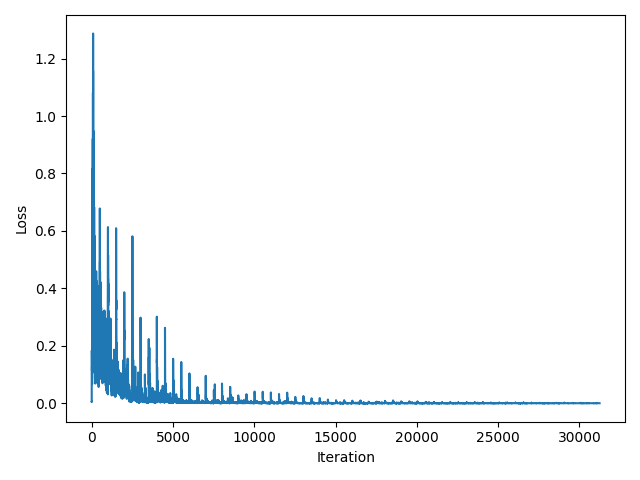

In [16]:
import matplotlib.pyplot as plt

width, height = 4, 4
max_itr = 1000

modell = Model()
controller = Controller()

storage = Storage(max_itr)
trainer = Trainer(max_itr)

agent = Agent(
    0,
    State.get_possible_states(width, height),
    State.get_possible_actions(),
)
grid = Grid(width, height)
grid.add_agent(agent)

trainer.bind(modell, storage, grid, [agent])

modell.set_grid(grid).add_agent(agent).reset()
controller.bind(modell).add_helper(storage, trainer)

trainer.train(2500)
fig2, ax2 = plt.subplots()
MLGraph(storage.ml_losses, fig2, ax2).show()

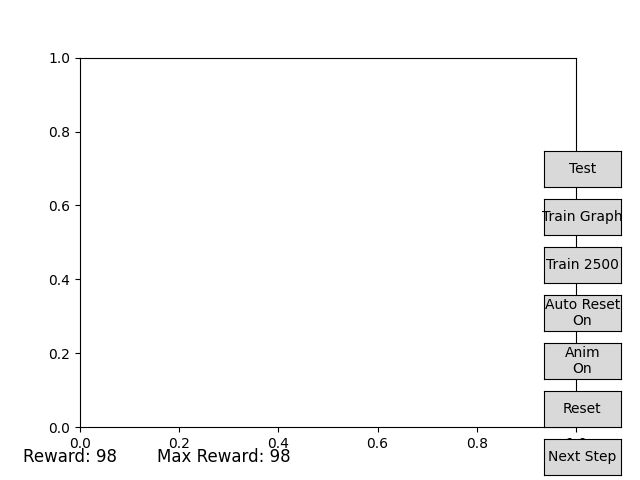

In [17]:
fig1, ax1 = plt.subplots()
vis = Visualization(fig1, ax1)
vis.bind(modell, controller, storage).show()